In [1]:
#Genetic Algorithm to Trade Stocks Based on Indicators (GATSBI) v1.0
import alpaca_trade_api as tradeapi
from alpaca_trade_api import TimeFrame
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import random
import numpy as np
from statistics import mean
from copy import deepcopy

In [2]:
BASE_URL = 'https://paper-api.alpaca.markets'
ALPACA_API_KEY = 'PKH15E01MGRA54FBEYRI'
ALPACA_SECRET_KEY = '4U5Q9fPaNDGp8Krj2lYG5NOxjYqqftYQWAlzmxwe'

api = tradeapi.REST(key_id=ALPACA_API_KEY, secret_key=ALPACA_SECRET_KEY, 
                    base_url=BASE_URL, api_version='v2')

transaction_type = ['buy', 'sell']

In [67]:
class Agent:
    def __init__(self, data, g):
        self.g = g
        self.data = data
    def randomize(self):
        self.g = []
        self.g.append(random.randint(2,50))
        self.g.append(random.randint(self.g[0], 50))
            
    def execute(self):
        self.data['EMA1'] = self.data['close'].ewm(span=self.g[0], adjust=False).mean()
        self.data['EMA2'] = self.data['close'].ewm(span=self.g[1], adjust=False).mean()
        self.data['SAFETY_EMA'] = self.data['close'].ewm(span=200, adjust=False).mean()
        self.data['cross'] = 0.0
        self.data['cross'] = np.where(self.data['EMA1'] > self.data['EMA2'] , 1.0, 0.0)
        self.data['safety'] = 0.0
        self.data['safety'] = np.where(self.data['close'] < self.data['SAFETY_EMA'], 1.0, 0.0)
        self.data['comb'] = 0.0
        self.data['comb'] = np.where(self.data['safety'] == self.data['cross'], 1.0, 0.0)
        self.data['signal'] = self.data['comb'].diff()
        map_dict = {-1.0: 'sell', 1.0: 'buy', 0.0: 'none'}
        self.data["signal"] = self.data["signal"].map(map_dict)
        
        self.calculate_fitness()
        
        return self.data
    
    def calculate_fitness(self):
        self.transaction_data = self.data[self.data['signal'].isin(transaction_type)]
        signal = self.transaction_data['signal'].tolist()
        close = self.transaction_data['close'].tolist()
        self.fitness = 0.0
        for i in range(1,len(signal)):
            if signal[i-1] == 'buy' and signal[i] == 'sell':
                self.fitness = self.fitness + (close[i] - close[i-1])
                #print('buy-sell performance: ' + str((close[i] - close[i-1])))
            elif signal[i-1] == 'sell' and signal[i] == 'buy':
                self.fitness = self.fitness + (close[i-1] - close[i])
                #print('sell-buy performance: ' + str((close[i-1] - close[i])))
        return self.fitness
    
    def plot(self):
        plt.figure(figsize=(15,5))
        plt.plot(self.data['close'])
        plt.plot(self.data['EMA1'])
        plt.plot(self.data['EMA2'])
        plt.plot(self.data['SAFETY_EMA'])

        plt.plot(self.data[self.data['signal'] == 'buy'].index,
                 self.data['close'][self.data['signal'] == 'buy'],
                 '^', markersize=8, color='g', label='buy')

        plt.plot(self.data[self.data['signal'] == 'sell'].index,
                 self.data['close'][self.data['signal'] == 'sell'],
                 'v', markersize=8, color='r', label='sell')

        plt.xlabel("Date")
        plt.ylabel("Close Price ($)")
        plt.legend()
        plt.show()

    
        
                
                

In [4]:
class Population:
    def __init__(self, n, m, data, pop):
        self.pop = pop
        self.n = n
        self.m = m
        self.data = data
        
    def randomize(self):
        self.pop = []
        for i in range(self.n):
            self.pop.append(Agent(self.data.copy(), []))
            self.pop[i].randomize()
    
    def execute(self):
        for i in range(len(self.pop)):
            self.pop[i].execute()
            
    def selection(self):
            
        choice = random.choices(self.pop, k = 5)
        sort = sorted(choice, key=lambda agent: agent.fitness, reverse=True)
        debug = []
        for x in sort:
            debug.append(x.fitness)
            
        return deepcopy(sort[0])
    
    def calculate_fitness(self):
        for agent in self.pop:
            agent.calculate_fitness()
    
    def mutate(self):
        for agent in self.pop:
            if random.uniform(0,1) <= self.m:
                if random.uniform(0,1) > 0.5:
                    agent.g = [random.randint(2,agent.g[1]), agent.g[1]]
                else:
                    agent.g = [agent.g[0], random.randint(agent.g[0],50)]
        
    
    def avg_fitness(self):
        fitness = []
        for agent in self.pop:
            fitness.append(agent.fitness)
        return mean(fitness)
    
    def best_agent(self):
        high = -100000.0
        best = None
        for agent in self.pop:
            if agent.fitness > high:
                high = agent.fitness
                best = agent
        return best
    
    def next_generation(self):
        new = []
        new.append(self.best_agent())
        '''for i in range(self.n-2):
            parent1 = self.selection()
            parent2 = self.selection()
            child = Agent(self.data, [0,0])
            if (random.uniform(0,1) < 0.5):
                child.g[0] = parent1.g[0]
            else:
                child.g[0] = parent2.g[0] 
            if (random.uniform(0,1) < 0.5):
                child.g[1] = parent1.g[1]
            else:
                child.g[1] = parent2.g[1]
            new.append(child)'''
        for i in range(self.n-1):
            new.append(self.selection())
        
        return Population(self.n, self.m, self.data, new)

In [5]:
def run_ga(gens, population):
    for gen in range(gens):
        print('Started Gen ' + str(gen))
        population.mutate()
        population.execute()
        population.calculate_fitness()
        print('Average Fitness: ' + str(population.avg_fitness()))
        print('Highest Fitness: ' + str(population.best_agent().fitness))
        population = population.next_generation()
    return population

In [40]:
input = api.get_bars("UGL", TimeFrame.Day, start = "2008-12-05", adjustment='raw').df
input = input.drop(['open', 'high', 'low', 'volume', 'trade_count', 'vwap'], axis=1)
pop = Population(1000, 0.04, input, [])
pop.randomize()
optimized_pop = run_ga(200, pop)

Started Gen 0
Average Fitness: -7.376303899999992
Highest Fitness: 25.51290000000003
Started Gen 1
Average Fitness: 9.17155580000001
Highest Fitness: 25.51290000000003
Started Gen 2
Average Fitness: 18.408683500000016
Highest Fitness: 25.51290000000003
Started Gen 3
Average Fitness: 23.009556700000022
Highest Fitness: 25.51290000000003
Started Gen 4
Average Fitness: 24.31994380000003
Highest Fitness: 25.51290000000003
Started Gen 5
Average Fitness: 24.51863200000003
Highest Fitness: 25.51290000000003
Started Gen 6
Average Fitness: 24.17867170000003
Highest Fitness: 25.51290000000003
Started Gen 7
Average Fitness: 24.61259210000003
Highest Fitness: 25.51290000000003
Started Gen 8
Average Fitness: 24.61402560000003
Highest Fitness: 25.51290000000003
Started Gen 9
Average Fitness: 24.68752950000003
Highest Fitness: 25.51290000000003
Started Gen 10
Average Fitness: 24.500313100000028
Highest Fitness: 25.51290000000003
Started Gen 11
Average Fitness: 24.72101950000003
Highest Fitness: 25.51

Average Fitness: 24.65228640000003
Highest Fitness: 25.51290000000003
Started Gen 98
Average Fitness: 24.517225600000028
Highest Fitness: 25.51290000000003
Started Gen 99
Average Fitness: 24.59174370000003
Highest Fitness: 25.51290000000003
Started Gen 100
Average Fitness: 24.52938980000003
Highest Fitness: 25.51290000000003
Started Gen 101
Average Fitness: 24.79085830000003
Highest Fitness: 25.51290000000003
Started Gen 102
Average Fitness: 24.73350930000003
Highest Fitness: 25.51290000000003
Started Gen 103
Average Fitness: 24.36647520000003
Highest Fitness: 25.51290000000003
Started Gen 104
Average Fitness: 24.79804040000003
Highest Fitness: 25.51290000000003
Started Gen 105
Average Fitness: 24.55944450000003
Highest Fitness: 25.51290000000003
Started Gen 106
Average Fitness: 24.521393300000028
Highest Fitness: 25.51290000000003
Started Gen 107
Average Fitness: 24.32893420000003
Highest Fitness: 25.51290000000003
Started Gen 108
Average Fitness: 24.73562460000003
Highest Fitness: 25

Average Fitness: 24.65541730000003
Highest Fitness: 25.51290000000003
Started Gen 194
Average Fitness: 24.49245880000003
Highest Fitness: 25.51290000000003
Started Gen 195
Average Fitness: 24.72433910000003
Highest Fitness: 25.51290000000003
Started Gen 196
Average Fitness: 24.772711500000028
Highest Fitness: 25.51290000000003
Started Gen 197
Average Fitness: 24.45106940000003
Highest Fitness: 25.51290000000003
Started Gen 198
Average Fitness: 24.28588830000003
Highest Fitness: 25.51290000000003
Started Gen 199
Average Fitness: 24.40979420000003
Highest Fitness: 25.51290000000003


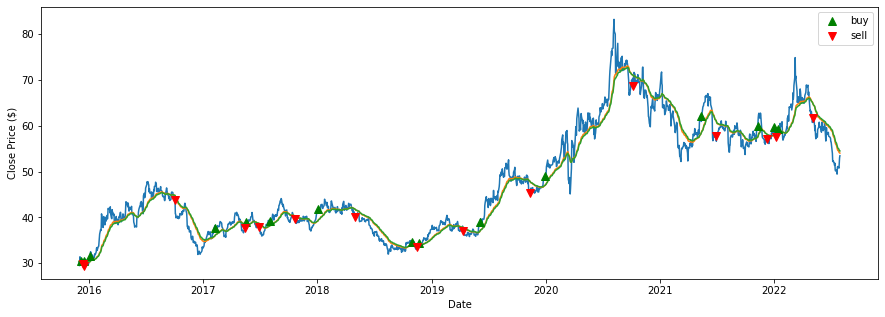

In [41]:
optimized_pop.best_agent().plot()

In [42]:
print(optimized_pop.best_agent().g)

[35, 40]


In [43]:
print(optimized_pop.best_agent().fitness)

25.51290000000003


In [44]:
print(optimized_pop.best_agent().data)

                             close       EMA1       EMA2  cross signal
timestamp                                                             
2015-12-01 05:00:00+00:00  30.3533  30.353300  30.353300    0.0    NaN
2015-12-02 05:00:00+00:00  29.4300  30.302006  30.308261    0.0   none
2015-12-03 05:00:00+00:00  30.0299  30.286889  30.294682    0.0   none
2015-12-04 05:00:00+00:00  31.3800  30.347617  30.347625    0.0   none
2015-12-07 05:00:00+00:00  30.5001  30.356088  30.355063    1.0    buy
...                            ...        ...        ...    ...    ...
2022-07-25 04:00:00+00:00  50.8895  54.432734  54.952323    0.0   none
2022-07-26 04:00:00+00:00  50.7300  54.227027  54.746356    0.0   none
2022-07-27 04:00:00+00:00  52.0200  54.104414  54.613363    0.0   none
2022-07-28 04:00:00+00:00  53.0300  54.044724  54.536126    0.0   none
2022-07-29 04:00:00+00:00  53.4317  54.010667  54.482251    0.0   none

[1677 rows x 5 columns]


In [45]:
for agent in optimized_pop.pop:
    print(agent.g)

[35, 40]
[35, 40]
[34, 41]
[35, 40]
[35, 40]
[34, 41]
[34, 41]
[34, 41]
[35, 40]
[35, 40]
[35, 40]
[34, 41]
[34, 41]
[35, 40]
[35, 40]
[34, 41]
[35, 40]
[35, 40]
[35, 40]
[35, 40]
[35, 40]
[34, 41]
[35, 40]
[34, 41]
[35, 40]
[35, 40]
[34, 41]
[34, 41]
[34, 41]
[34, 41]
[34, 41]
[34, 41]
[35, 40]
[34, 41]
[35, 40]
[34, 41]
[34, 41]
[34, 41]
[35, 40]
[35, 40]
[34, 41]
[34, 41]
[34, 41]
[35, 40]
[34, 41]
[34, 41]
[34, 41]
[35, 40]
[35, 40]
[35, 40]
[34, 41]
[35, 40]
[34, 41]
[35, 40]
[35, 40]
[34, 41]
[35, 40]
[34, 41]
[35, 40]
[35, 40]
[34, 41]
[34, 41]
[35, 40]
[34, 41]
[35, 40]
[34, 41]
[35, 40]
[34, 41]
[34, 41]
[34, 41]
[34, 41]
[35, 40]
[35, 40]
[35, 40]
[35, 40]
[34, 41]
[35, 40]
[34, 41]
[35, 40]
[34, 41]
[34, 41]
[35, 40]
[34, 41]
[35, 40]
[35, 40]
[35, 40]
[34, 41]
[35, 40]
[35, 40]
[34, 41]
[34, 41]
[35, 40]
[35, 40]
[35, 40]
[34, 41]
[34, 41]
[35, 40]
[35, 40]
[35, 40]
[34, 41]
[34, 41]
[34, 41]
[34, 41]
[35, 40]
[35, 40]
[35, 40]
[35, 40]
[35, 40]
[35, 40]
[34, 41]
[35, 40]
[

In [70]:
gold_data = api.get_bars("UGL", TimeFrame.Day, start = "2008-12-05", adjustment='raw').df
gold_agent = Agent(gold_data, [35,40])
gold_agent.execute()
gold_agent.calculate_fitness()

-41.94220000000001

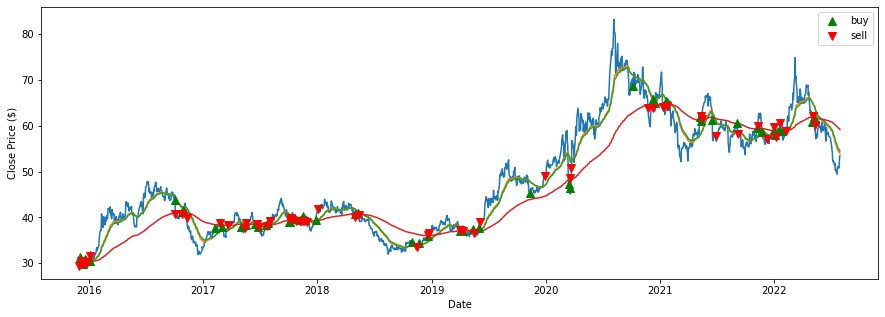

In [71]:
gold_agent.plot()